#### Data: http://nodobo.com/release.html

### Loading libraries

In [1]:
import bz2
import pandas as pd
import numpy as np
import sqlite3
import json
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

### Decompress BZ2 file and convert sqlite file to pandas Data Frames

In [2]:
with open('./Raw Data/db.sqlite3.dump.bz2', 'rb') as inputFile:
        decompressor = bz2.BZ2Decompressor()
        for data in iter(lambda : inputFile.read(), b''):
            Decompressed_data=decompressor.decompress(data)

In [17]:
conn=sqlite3.connect('./SQL_Database.db')
# c=conn.cursor()
# sqlCommands=Decompressed_data.split(';')
# for command in sqlCommands[0:len(sqlCommands)-2]:
#     c.execute(command)
Calls_data=pd.read_sql_query('SELECT * FROM calls',conn)
conn.close()

Calls_data.head()

,id,user_id,other_id,interaction,timestamp,number,call_timestamp,duration,direction,created_at,updated_at
0,1,4,NaN,94970,2010-09-15 19:21:30,07434677419,2010-09-15 19:17:44,211,Incoming,2010-11-11 10:20:57,2010-11-11 10:20:57
1,2,23,NaN,95598,1980-02-11 07:19:15,01666472054,1980-02-11 07:18:23,31,Outgoing,2010-11-11 10:20:57,2010-11-11 10:20:57
2,3,23,NaN,95674,1980-02-11 07:46:38,07371326239,1980-02-11 07:45:42,45,Incoming,2010-11-11 10:20:57,2010-11-11 10:20:57
3,4,23,8.0,95725,1980-02-11 08:05:04,07681546436,1980-02-11 08:04:42,10,Outgoing,2010-11-11 10:20:57,2010-11-11 10:20:57
4,5,23,8.0,95728,1980-02-11 08:05:43,07681546436,1980-02-11 08:05:31,0,Outgoing,2010-11-11 10:20:57,2010-11-11 10:20:57


In [18]:
conn=sqlite3.connect('./SQL_Database.db')
Message_data=pd.read_sql_query('SELECT * FROM messages',conn)
conn.close()

Message_data.head()

,id,user_id,other_id,interaction,timestamp,number,message_timestamp,length,direction,created_at,updated_at
0,3,4,NaN,94930,2010-09-15 19:01:54,07684763671,2010-09-15 19:01:54,28,Incoming,2010-11-11 10:29:54,2010-11-11 10:29:54
1,4,23,8.0,95547,1980-02-11 07:08:49,07681546436,1980-02-11 07:08:49,7,Incoming,2010-11-11 10:29:54,2010-11-11 10:29:54
2,5,23,8.0,95575,1980-02-11 07:14:07,07681546436,1980-02-11 07:14:05,6,Outgoing,2010-11-11 10:29:54,2010-11-11 10:29:54
3,6,23,13.0,96014,2010-09-09 21:43:47,07981267897,2010-09-09 21:43:44,41,Outgoing,2010-11-11 10:29:54,2010-11-11 10:29:54
4,7,13,26.0,96251,1980-01-07 22:58:31,07784425582,1980-01-07 22:58:28,75,Outgoing,2010-11-11 10:29:54,2010-11-11 10:29:54


In [19]:
conn=sqlite3.connect('./SQL_Database.db')
User_data=pd.read_sql_query('SELECT * FROM users',conn)
conn.close()

User_data.head()

,id,name,number,created_at,updated_at
0,1,Anonymous,07839321359,2010-11-11 10:19:34,2010-11-11 10:19:34
1,2,Anonymous,07690700998,2010-11-11 10:19:34,2010-11-11 10:19:34
2,3,Anonymous,07195393761,2010-11-11 10:19:34,2010-11-11 10:19:34
3,4,Anonymous,07610039694,2010-11-11 10:19:34,2010-11-11 10:19:34
4,5,Anonymous,07375968743,2010-11-11 10:19:34,2010-11-11 10:19:34


### Prepare Graph Data

#### Nodes Data with On-net/Off-net Information

In [20]:
Nodes_df=pd.DataFrame(Calls_data.number.append(User_data.number).drop_duplicates())
Nodes_df['Network']=Nodes_df.apply(lambda row: "On-net" if (row['number'] in set(User_data.number)) else "Off-net",axis=1)
Nodes_df['nodes']=Nodes_df.apply(lambda row: (row['number'],{'Network':row['Network']}),axis=1)

In [21]:
Nodes=list(Nodes_df.nodes)

#### Edge Data with Additional Attributes

###### Calls

In [22]:
Calls_data['user_number']=Calls_data['user_id'].map(User_data.set_index('id')['number'])
Calls_data.rename(columns={'number':'other_number'},inplace=True)

In [23]:
Edge_calls_df=Calls_data[['user_number','other_number','duration']][Calls_data.duration>0]

Edge_calls_df['edge_node_1']=Edge_calls_df.apply(lambda row: row['user_number'] \
                                                      if row['user_number']<=row['other_number'] else row['other_number'] \
                                                     ,axis=1)
Edge_calls_df['edge_node_2']=Edge_calls_df.apply(lambda row: row['other_number'] \
                                                      if row['user_number']<=row['other_number'] else row['user_number'] \
                                                     ,axis=1)

In [30]:
Edge_df.to_csv('Edge_df.csv')

In [31]:
Nodes_df.to_csv('Nodes_df.csv')

###### Messages

In [24]:
Message_data['user_number']=Message_data['user_id'].map(User_data.set_index('id')['number'])
Message_data.rename(columns={'number':'other_number'},inplace=True)

In [25]:
## We will just consider sent messages
Edge_messages_df=Message_data[['user_number','other_number','length']][Message_data.direction=='Outgoing']

Edge_messages_df['edge_node_1']=Edge_messages_df.apply(lambda row: row['user_number'] \
                                                      if row['user_number']<=row['other_number'] else row['other_number'] \
                                                     ,axis=1)
Edge_messages_df['edge_node_2']=Edge_messages_df.apply(lambda row: row['other_number'] \
                                                      if row['user_number']<=row['other_number'] else row['user_number'] \
                                                     ,axis=1)

###### Consolidated Edge Data Frame

In [26]:
## Total call duration and count
Edge_df=Edge_calls_df[['edge_node_1','edge_node_2','duration']] \
        .groupby(['edge_node_1','edge_node_2'],as_index=False).sum()
Edge_df=Edge_df.merge(Edge_calls_df[['edge_node_1','edge_node_2','duration']] \
                      .groupby(['edge_node_1','edge_node_2'],as_index=False).count() \
                      .rename(columns={'duration':"call_count"}) \
                ,on=['edge_node_1','edge_node_2'], how='left')

In [27]:
## Total message length and count
Edge_df=Edge_df.merge(Edge_messages_df[['edge_node_1','edge_node_2','length']] \
                      .groupby(['edge_node_1','edge_node_2'],as_index=False).sum() \
                      .rename(columns={'length':"sent_messages_length"}) \
                ,on=['edge_node_1','edge_node_2'], how='left')
Edge_df=Edge_df.merge(Edge_messages_df[['edge_node_1','edge_node_2','length']] \
                      .groupby(['edge_node_1','edge_node_2'],as_index=False).count() \
                      .rename(columns={'length':"sent_messages_count"}) \
                ,on=['edge_node_1','edge_node_2'], how='left')

In [28]:
## Filtering out edges with call count < 1 and duration < 2 minutes
Edge_df=Edge_df[(Edge_df.call_count>1) & (Edge_df.duration>=120)]

In [29]:
## Scaling duration
Edge_df['weight']=Edge_df['duration'].map(lambda x:x/Edge_df['duration'].mean())

In [485]:
Edge_df['edges']=Edge_df.apply(lambda row: (row['edge_node_1'],row['edge_node_2'] \
                                            ,{'weight':row['weight'] \
                                              ,'call_count':row['call_count'] \
                                              ,'sent_messages_length':row['sent_messages_length'] \
                                              ,'sent_messages_count':row['sent_messages_count']}) \
                               ,axis=1)
Edges=list(Edge_df.edges)

### Create Graph

In [521]:
G=nx.Graph()
G.add_nodes_from(Nodes)
G.add_edges_from(Edges)
node_color_dict={'On-net':'green','Off-net':'red'}
G.remove_nodes_from((n for n,d in G.degree_iter() if d==0))
node_color=[node_color_dict[G.node[n]['Network']] for n in G.nodes()]

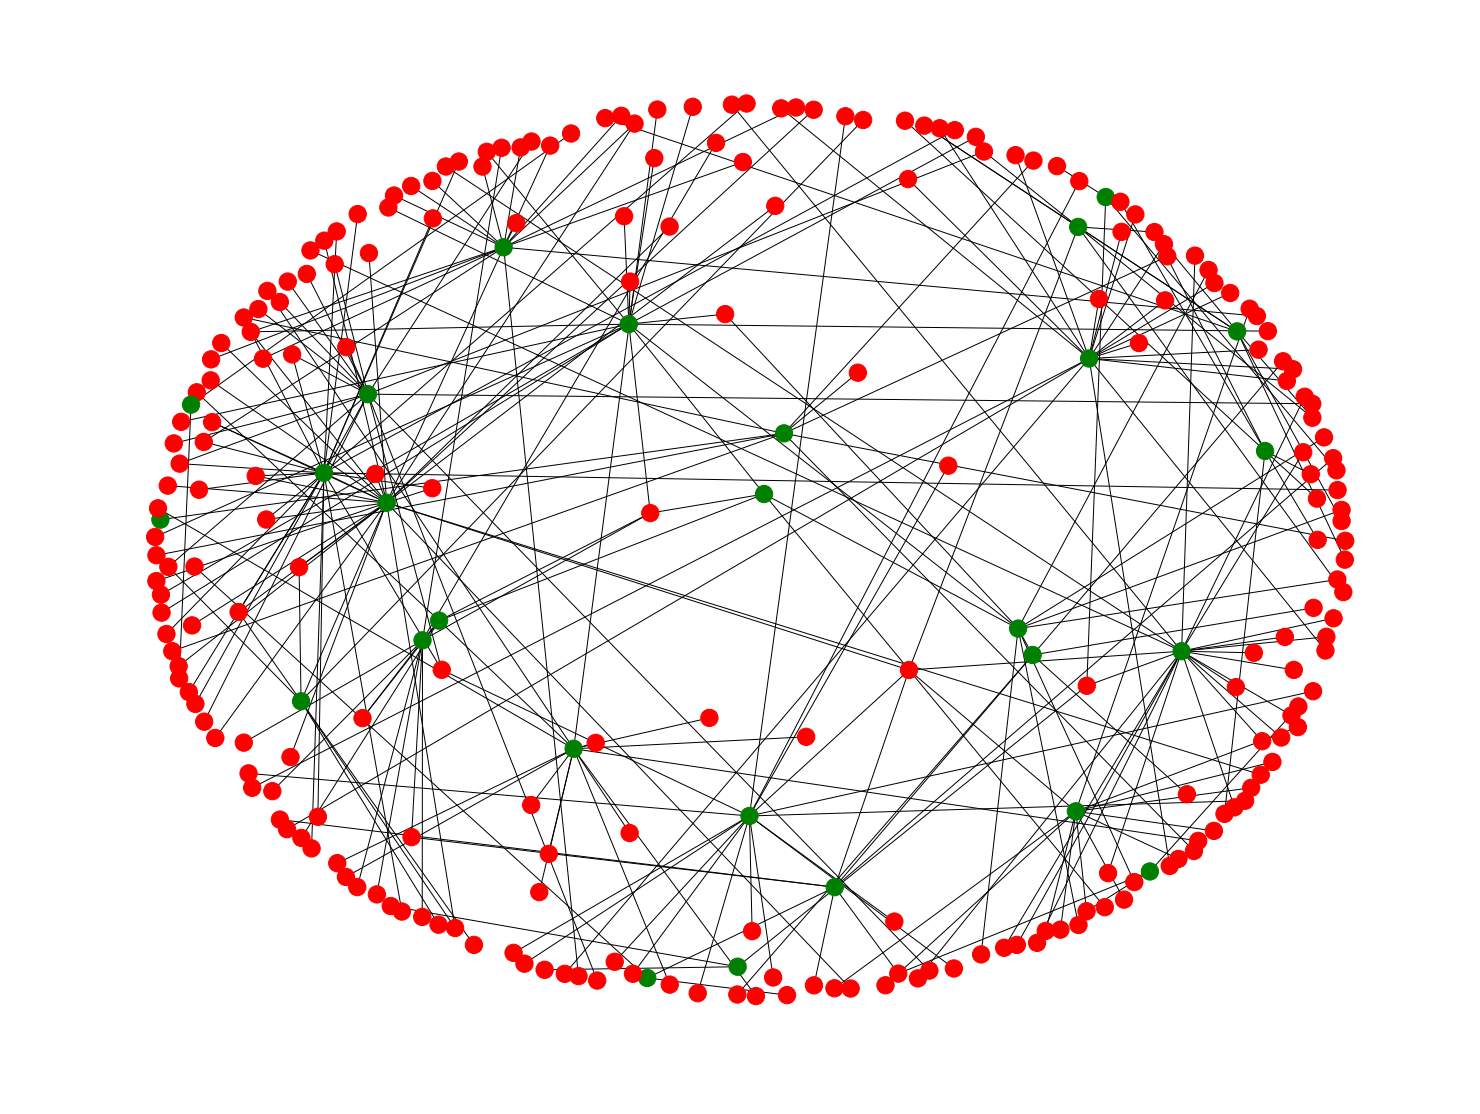

In [524]:
plt.figure(figsize=(20,15))
nx.draw(G,node_color=node_color)

### Add Metrics

In [539]:
for ix,deg in G.degree_iter():
    G.node[ix]['degree']=deg

for ix,deg in nx.betweenness_centrality(G).items():
    G.node[ix]['betweenness']=deg

for ix,deg in nx.closeness_centrality(G).items():
    G.node[ix]['closeness']=deg

### Export Data for D3

In [545]:
from networkx.readwrite import json_graph
d3_data=json_graph.node_link_data(G)
with open('D3 Graph/graph.json','w') as f:
    json.dump(d3_data,f,indent=4)